<font size="8"> **Accessing sea ice concentration data from NASA Goddard** </font>  
This notebook access the [NASA Goddard-merged Near Real Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration](https://climatedataguide.ucar.edu/climate-data/sea-ice-concentration-data-nasa-goddard-and-nsidc-based-nasa-team-algorithm) (version 3) dataset available in Gadi.  
  
The notebook also applies some corrections to the observational data to cover missing data for some dates between 1979 and 1988.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [ ]:
import os
#Ensure you update this filepath if you have saved these notebooks elsewhere in your machine
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading relevant libraries

In [2]:
#Loading and manipulating data
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
import re
from glob import glob
from dask.distributed import Client
import rioxarray
import xesmf as xe

#Analysis module
import UsefulFunctions as uf

#Packages for plotting
import matplotlib.pyplot as plt

#Show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

## Parallelising work

In [3]:
client = Client()

# Defining dictionary of useful variables
In this dictionary we will define a variables that will be used multiple times throughout this notebook to avoid repetition. It will mostly contain paths to folders where intermediate or final outputs will be stored.

In [4]:
varDict =  {'expt': '01deg_jra55v140_iaf_cycle4',
            'Observations': '/g/data/v45/la6889/Chapter2_Crabeaters/SeaIceObs'}

# Accessing sea ice concentration data from observations
Data for the ACCESS-OM2-01 model and satellite observations are available in GADI. The observational data has some missing data between 1979 and 1988. We will interpolate data for the missing periods as described in the next section.

In [44]:
#Observational data file path to main folder location
ObsDir = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3'

#Get a list of all files inside the year folders
obsSHFileList = sorted(glob(os.path.join(ObsDir, 'south/daily/*/*'), recursive = True))

# Load all files that are within the years of interest
for year in np.arange(1978, 2020):
    #Create an empty list to hold all filepaths
    fileList = []
    for file in obsSHFileList:
        #Extracting full date (8 digits long) and then comparing with year (first 4 digits)
        if str(year) in re.search("[0-9]{8}", file).group(0)[:4]:
            #Only one variable 'goddard_merged_seaice_conc' is loaded as it is the only one of interest
            dataarray = xr.open_dataset(file, decode_times = False, autoclose = True)['goddard_merged_seaice_conc']
            fileList.append(dataarray)
    #Create a new data array with all time steps
    fileList = xr.concat(fileList, dim = 'time', coords = 'minimal')    
    if 'time' in fileList.coords:
        #Apply the same time units given in time dimension to time coordinates
        time_units = fileList.time.units
        #Decode date time data to CF conventions
        decoded_time = xr.conventions.times.decode_cf_datetime(fileList.time, time_units)
        fileList.coords['time'] = ('time', decoded_time,
                                   {'long_name': 'time', 'decoded_using': time_units})
    # replace values outside valid range (0-1) with nan
    fileList = fileList.where((fileList >= 0) & (fileList <= 1), np.nan)
    
    #Save data array in the observations folder
    os.makedirs(varDict['Observations'], exist_ok = True)
    fileList.to_netcdf(os.path.join(varDict['Observations'], f'sea_ice_conc_obs_{str(year)}.nc'))

# Dealing with missing dates in sea ice concentration from observations
Data is not available for some periods in the observational data. We applied two different corrections as described in [Masson et al 2013](https://doi.org/10.1371/journal.pone.0064756):  
1. Between January 1979 and November 1987, days of missing data were interpolated from adjoining days  
2. Between December 1987 and January 1988, missing days were replaced with daily climatology (1979-2009)  

## Correcting data between Jan 1979 and Nov 1987
First, we load the data for this period as a data array.

In [13]:
#Getting a list of all SIC observations saved in previous step
obs_list = sorted(glob(os.path.join(varDict['Observations'], '*.nc')))

#Loading data for the period between 1979 and 1987 - First correction
obs_da = []
#Looking for files between period of interest and loading as data array
for yr in np.arange(1978, 1988):
    [obs_da.append(xr.open_dataarray(f)) for f in obs_list if str(yr) in f]

#Concatening all files together
obs_da = xr.concat(obs_da, dim = 'time').sortby('time')

Now we will identify the missing dates, interpolate data from adjoining days and include these in a corrected dataset.

In [18]:
#Get list of dates not included in observational data
obs_time = obs_da.time.values
complete_time = pd.date_range(obs_da.time.values.min(), obs_da.time.values.max()).values

#Find missing days
miss_days = list(set(obs_time) ^ set(complete_time))

#Create an empty list to hold interpolated days
int_data = []

#Interpolate only days that are missing
for md in miss_days:
    #Select the day prior and the day after missing date
    int_range = obs_da.sel(time = slice(md-np.timedelta64(1, 'D'), md+np.timedelta64(1, 'D')))
    #Perform interpolation
    int_range = int_range.interp(time = pd.date_range(md - np.timedelta64(1, 'D'), md + np.timedelta64(1, 'D')))
    #Save interpolated missing date in a list
    int_data.append(int_range.sel(time = md))

#Create a new array with missing dates
obs_corr = xr.concat([obs_da, xr.concat(int_data, dim = 'time')], dim = 'time').sortby('time')

#Remove variables no longer in use
del obs_da, obs_time, complete_time, miss_days

We will merge the interpolated data with the original observational data from 1988 to 2009.

In [23]:
#Create empty list to hold file list
obs_da = []

#Load data arrays
for yr in np.arange(1988, 2010):
    [obs_da.append(xr.open_dataarray(f)) for f in obs_list if str(yr) in f]

#Create a new data array to calculate climatology. Joining original files just loaded and the interpolated data
obs_clim = xr.concat([obs_corr.where(obs_corr.time.dt.year >= 1979, drop = True),
                      xr.concat(obs_da, dim = 'time')], dim = 'time')

### Saving corrected data between Jan 1979 and Nov 1987

In [57]:
for yr in np.arange(1979, 1988):
    obs_clim.sel(time = str(yr)).to_netcdf(os.path.join(varDict['Observations'], f'sea_ice_conc_obs_{str(yr)}.nc'))

Finally, we will check that there are no other missing days outside the period that we corrected in the previous steps. If there are, we will interpolate from adjoining dates.

In [26]:
#Get list of dates not included in observational data
obs_time = obs_clim.time.values
complete_time = pd.date_range(obs_clim.time.values.min(), obs_clim.time.values.max()).values

#Find missing days
miss_days = list(set(obs_time) ^ set(complete_time))

#Checking that there are no missing dates outside 1987-1988
int_dates = []
[int_dates.append(i) for i in miss_days if str(pd.Timestamp(i).year) not in ['1987', '1988']]

#Creating missing list to store data
int_da = []
#Looping through missing dates
for d in int_dates:
    int_range = obs_clim.sel(time = slice(d-np.timedelta64(1, 'D'), d+np.timedelta64(1, 'D')))
    #Perform interpolation
    int_range = int_range.interp(time = pd.date_range(d-np.timedelta64(1, 'D'), d+np.timedelta64(1, 'D')))
    #Save interpolated missing date in a list
    int_da.append(int_range.sel(time = d))
    #Save data for years where data has been interpolated
    yr = str(pd.Timestamp(d).year)
    int_da.append(obs_clim.sel(time = yr))
    #Join to rest of the year being corrected
    int_da = xr.concat(int_da, dim = 'time').sortby('time')
    #Save corrected year
    int_da.to_netcdf(os.path.join(varDict['Observations'], f'sea_ice_conc_obs_{str(yr)}.nc'))

In [36]:
#Removing full dataset to avoid memory overloading
del obs_clim

## Correcting data between Dec 1987 and Jan 1988
Any missing dates between this period will be replaced by the daily climatology calculated from the dataset corrected in the previous step.  
  
First, we calculate the daily climatological mean.

In [5]:
#Getting a list of all SIC observations saved in previous step
obs_list = sorted(glob(os.path.join(varDict['Observations'], '*.nc')))
#Keep only files between 1979 and 2009
obs_list = [i for i in obs_list if (int(re.findall('_([0-9]{4}).', i)[0]) > 1978) & (int(re.findall('_([0-9]{4}).', i)[0]) < 2010)]
#Load dataset
obs_clim = xr.open_mfdataset(obs_list).goddard_merged_seaice_conc
#Calculate climatology
daily_clim = obs_clim.groupby('time.dayofyear').mean('time')

Replacing missing days with daily climatology (1979-2009).

In [6]:
#Get list of dates not included in observational data
obs_time = obs_clim.time.values
complete_time = pd.date_range(obs_clim.time.values.min(), obs_clim.time.values.max()).values

#Find missing days
miss_days = list(set(obs_time) ^ set(complete_time))

#Replace missing dates with climatology
corr_dates = []
for md in miss_days:
    #Add a day to dates in 1987 because daily climatology includes leap day
    if '1987' in str(pd.to_datetime(md)):
        ind = pd.Timestamp(md).timetuple().tm_yday+1
    else:
        ind = pd.Timestamp(md).timetuple().tm_yday
    corr_dates.append(daily_clim.sel(dayofyear = ind).drop('dayofyear').expand_dims({'time': [md]}))

#Save everything in corrected data array
obs_clim = xr.concat([obs_clim, xr.concat(corr_dates, dim = 'time')], dim = 'time').sortby('time')

### Saving corrected data between 1987 and 1988

In [8]:
for yr in np.arange(1987, 1989):
    obs_clim.sel(time = str(yr)).to_netcdf(os.path.join(varDict['Observations'], f'sea_ice_conc_obs_{str(yr)}.nc'))

## Calculating monthly means from corrected observational dataset
We will use mean monthly data to model the distribution of crabeater seals. Thus, we will calculate monthly means before storing the data to disk.

In [9]:
#Defining folder where monthly means will be saved
folder_out = os.path.join(varDict['Observations'], 'monthly')
#Ensure folder exists
os.makedirs(folder_out, exist_ok = True)

#Loading each file - Calculate monthly means and save outputs
obs_list = sorted(glob(os.path.join(varDict['Observations'], '*.nc')))
for f in obs_list:
    #Open yearly SIC file
    da = xr.open_dataarray(f)
    #Getting year in file
    yr = da.time.dt.year
    #Ensuring there is data for only one year in the file
    if len(pd.unique(yr)) == 1:
        yr = pd.unique(yr)[0]
    else:
        print('More than one year included in data: ', pd.unique(yr))
    #Calculate monthly mean
    da = da.groupby('time.month').mean()
    #Creating monthly date to be included in data array (mid-month)
    dates = [pd.to_datetime(f'{yr}-{m}-15') for m in da.month.values]
    #Renaming month dimension as time
    da = da.rename({'month': 'time'})
    #Using corrected dates
    da['time'] = dates
    #Saving outputs
    da.to_netcdf(os.path.join(folder_out, f'monthly_mean_sic_obs_{str(yr)}.nc'))

# Regridding data to match ACCESS-OM2-01 grid
We will use this data as input to model crabeater seals distribution. Then, we will compare the results of the estimated distribution based on observational environmental data to that of the model. We will regrid observations to match the model outputs grid to facilitate the comparison of crabeater disribution.

## Loading all monthly means for SIC observations

In [5]:
# Loading monthly SIC observations
sic_monthly_obs = xr.open_mfdataset(sorted(glob(os.path.join(varDict['Observations'], 'monthly/*.nc')))).goddard_merged_seaice_conc
sic_monthly_obs

<xarray.DataArray 'goddard_merged_seaice_conc' (time: 494, ygrid: 332,
                                                xgrid: 316)>
dask.array<concatenate, shape=(494, 332, 316), dtype=float64, chunksize=(12, 332, 316), chunktype=numpy.ndarray>
Coordinates:
  * ygrid      (ygrid) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
  * xgrid      (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    longitude  (ygrid, xgrid) float64 dask.array<chunksize=(332, 316), meta=np.ndarray>
    latitude   (ygrid, xgrid) float64 dask.array<chunksize=(332, 316), meta=np.ndarray>
  * time       (time) datetime64[ns] 1978-11-15 1978-12-15 ... 2019-12-15
Attributes:
    valid_range:    [  0 100]
    long_name:      Goddard Edited Climate Data Record of Passive Microwave D...
    standard_name:  sea_ice_area_fraction
    units:          1
    flag_values:    [-5 -4 -3 -2 -1]
    flag_meanings:  pole_hole lakes coastal land_mask missing_data
    datum:          +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:   projection
    reference:      http://nsidc.org/data/nsidc-0051.html http://nsidc.org/da...

## Reprojecting SIC observations
Observations need to be reprojected from their original CRS, EPSG:3976, to WGS84 (EPSG:4326) which is the default for lat/lon coordinate pairs used in the ACCESS-OM2-01 model prior to attempting regridding. Otherwise, regridding will not work because the coordinates will be given in different units (meters in EPSG:3976 vs degrees in EPSG:4326).

In [6]:
#First, we will rename coordinates in observational data 
sic_monthly_obs = sic_monthly_obs.rename({'longitude': 'lon', 'latitude': 'lat',
                                          'xgrid': 'x', 'ygrid': 'y'})

#We can now reproject the observations
reproj_sic_obs = uf.calculate_latlon_coords(sic_monthly_obs, 'epsg:3976', 'epsg:4326')

#Adding a land mask
reproj_sic_obs['mask'] = xr.where(~np.isnan(reproj_sic_obs), 1, 0).isel(time = 0).squeeze().drop('time')

#Checking results
reproj_sic_obs

<xarray.DataArray 'goddard_merged_seaice_conc' (time: 494, y: 332, x: 316)>
dask.array<concatenate, shape=(494, 332, 316), dtype=float64, chunksize=(12, 332, 316), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
  * x        (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    lon      (y, x) float64 -42.23 -42.05 -41.87 -41.68 ... 135.4 135.2 135.0
    lat      (y, x) float64 -39.36 -39.49 -39.62 -39.75 ... -41.86 -41.72 -41.58
  * time     (time) datetime64[ns] 1978-11-15 1978-12-15 ... 2019-12-15
    mask     (y, x) int64 dask.array<chunksize=(332, 316), meta=np.ndarray>
Attributes:
    valid_range:    [  0 100]
    long_name:      Goddard Edited Climate Data Record of Passive Microwave D...
    standard_name:  sea_ice_area_fraction
    units:          1
    flag_values:    [-5 -4 -3 -2 -1]
    flag_meanings:  pole_hole lakes coastal land_mask missing_data
    datum:          +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:   projection
    reference:      http://nsidc.org/data/nsidc-0051.html http://nsidc.org/da...

If we plot the first time step of this dataset with default values, we will get the data in its original CRS. This is because it is using the `x` and `y` dimensions, which contain indices as the axes values.

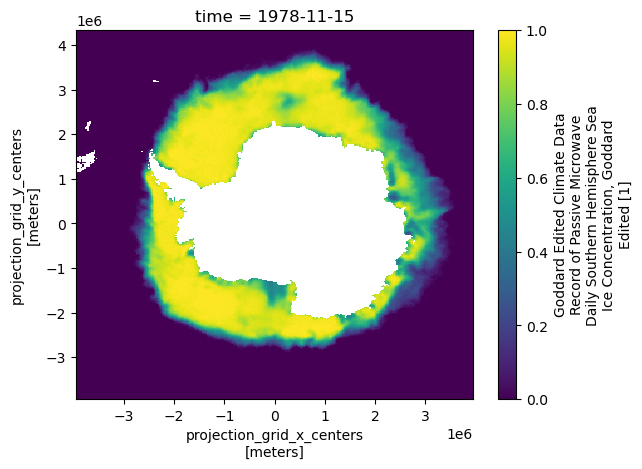

In [7]:
reproj_sic_obs.isel(time = 0).plot()

However, if we specify that we want to use `lat` and `lon` as the axes of our plot, we will get the unprojected version of this dataset (i.e., EPSG:4326).

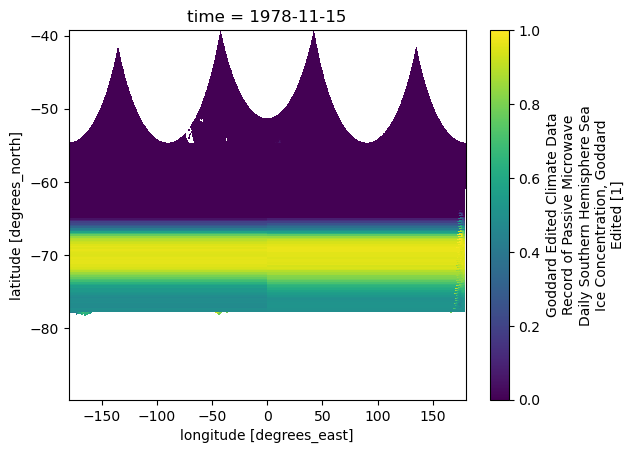

In [8]:
reproj_sic_obs.isel(time = 0).plot(x = 'lon', y = 'lat')

We have been successful at reprojecting the data, now we can regrid it to match the ACCESS-OM2-01 model grid.

## Loading ACCESS-OM2-01 sample grid
This is the grid that we want the SIC observations to have after regridding is done.

In [9]:
#Creating new COSIMA cookbook session
session = cc.database.create_session()

#Accessing the area of grid and keeping data for the Southern Ocean only
grid = cc.querying.getvar(varDict['expt'], 'area_t', session, n = 1).sel(yt_ocean = slice(-90, -45))
#Correcting longitude values to keep them between +/- 180
grid = uf.corrlong(grid)
#Renaming coordinates to match observations
grid = grid.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})
#Adding mask of land areas
grid['mask'] = xr.where(~np.isnan(grid), 1, 0)

#Checking results
grid

<xarray.DataArray 'area_t' (lat: 740, lon: 3600)>
dask.array<getitem, shape=(740, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -81.11 -81.07 -81.02 -80.98 ... -45.18 -45.11 -45.04
    mask     (lat, lon) int64 dask.array<chunksize=(540, 440), meta=np.ndarray>
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2022-04-27
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

## Regridding SIC data

In [10]:
#We only need to calculate the regridder once - Note that we use the reprojected SIC data
reg_hr = xe.Regridder(reproj_sic_obs, grid, 'bilinear')

#Now we apply the regridder
reg_obs = reg_hr(reproj_sic_obs)

#Checking results
reg_obs

<xarray.DataArray (time: 494, lat: 740, lon: 3600)>
dask.array<_regrid, shape=(494, 740, 3600), dtype=float64, chunksize=(12, 740, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1978-11-15 1978-12-15 ... 2019-12-15
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -81.11 -81.07 -81.02 -80.98 ... -45.18 -45.11 -45.04
    mask     (lat, lon) int64 dask.array<chunksize=(540, 440), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

Rechunking data to match ACCESS-OM2-01, which will facilitate calculations. We will also add a variable name to the data array. We will also drop the land mask because it is no longer needed.

In [11]:
reg_obs = reg_obs.chunk((1, 540, 720))
reg_obs.name = 'SIC'
reg_obs

<xarray.DataArray 'SIC' (time: 494, lat: 740, lon: 3600)>
dask.array<rechunk-merge, shape=(494, 740, 3600), dtype=float64, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1978-11-15 1978-12-15 ... 2019-12-15
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -81.11 -81.07 -81.02 -80.98 ... -45.18 -45.11 -45.04
    mask     (lat, lon) int64 dask.array<chunksize=(540, 720), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

We can plot the first time step of the regridded dataset.

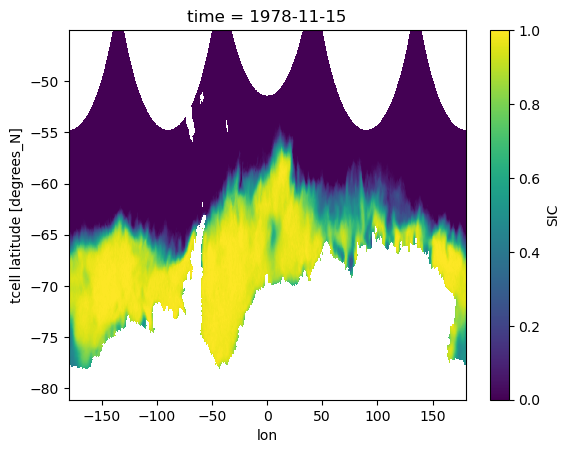

In [12]:
reg_obs.isel(time = 0).plot()

The curves appearing at the top section of the figure are due to the regridding. Since we do not expect sea ice to be present north of $55^{\circ}S$, we will replace these blank grid cells with zeroes (`0`).

Additionally, we will apply the land mask attached the regridded data array to remove any values from where the southern tip of South America should be.

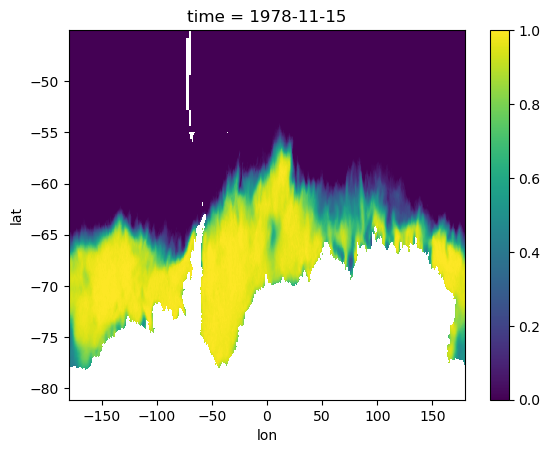

In [15]:
#We replace blank grid cells north of 55S with zeroes
reg_obs = xr.where((reg_obs.lat > -55) & (np.isnan(reg_obs)), 0, reg_obs)

#We apply the mask
reg_obs = xr.where(reg_obs.mask == 0, np.nan, reg_obs)

#Check results
reg_obs.isel(time = 0).plot()

We can compare this to the original data.

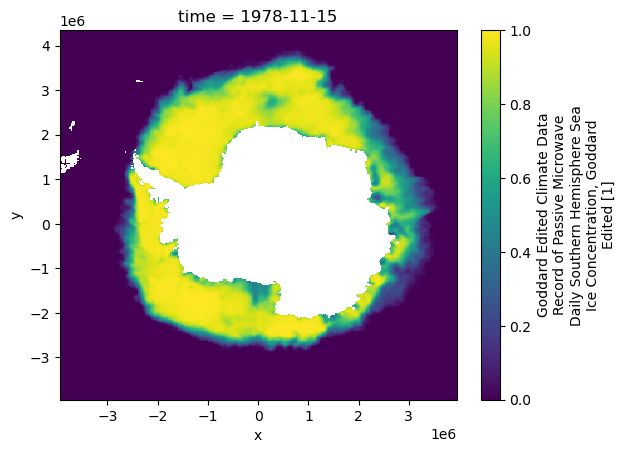

In [16]:
sic_monthly_obs.isel(time = 0).plot()

We can see that the spatiak paterns are similar. For example, there is no sea ice in the northermost tip of the Antarctic Peninsula. SIC in East Antarctica is not as high as in other areas, and the southernmost part of the Ross Sea has less sea ice than surrounding areas.

We will also calculate the maximum and minimum values of the original and regridded SIC data to make sure the regridding did not result in large change to the range of sea ice concentration values, which should be between 0.0 and 1.0.

In [17]:
print(sic_monthly_obs.min().values, sic_monthly_obs.max().values)

0.0 1.0


In [18]:
print(reg_obs.min().values, reg_obs.max().values)

0.0 1.0000000000000002


There is a small increase in the maximum value, but this increase is less than 0.001, which is not expected to impact any analyses. Now we are ready to save the results to disk.

# Saving masked regridded data to disk

In [28]:
#Defining folder where monthly means will be saved
folder_out = os.path.join(varDict['Observations'], 'regridded_monthly')
#Ensure folder exists
os.makedirs(folder_out, exist_ok = True)

#Dropping sea ice mask
reg_obs = reg_obs.squeeze().drop('mask')
#Adding variable name to data array
reg_obs.name = 'SIC'
#Ensuring time and coordinates are in the same order as originally
reg_obs = reg_obs.transpose('time', 'lat', 'lon')
#Rename coordinates to match ACCESS-OM2 model outputs
reg_obs = reg_obs.rename({'lat': 'yt_ocean', 'lon': 'xt_ocean'})

#Saving as yearly data
for yr in np.unique(reg_obs.time.dt.year):
    reg_obs.sel(time = str(yr)).to_netcdf(os.path.join(folder_out, f'regridded_SIC_obs_{str(yr)}.nc'))